# Post-Process 3D Input

There are many cases were you may want to post-process components from a 3D GCM output. Post-processing is used to compensate for simplicities, or assumptions within a GCM. For example, you may want to post-process clouds on your output spectra, even if your initial GCM run did not include the effects of clouds. 

In this notebook you will learn: 
1. How to post- process chemistry 
2. How to post- process simple box model clouds 
3. How to post-process `virga` model clouds

You should already know: 
1. How to format and regrid an `xarray` dataset

Next notebook you will learn:
1. How to create spectra and phase curves from 3D input

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xarray as xr

from picaso import justdoit as jdi

In [2]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True)

## Post-Process Chemistry: User Options

1. User-defined input: this would only be used to explore simplistic cases (e.g. 100% H2O, or 50/50 H2/H2O). It also might be the case that you have abundance models from elsewhere (e.g. 3D model or GCM) and want to add it to your pressure/temperature `xarray` 

2. Computationally intensive route: Usually GCM output is at a very high spatial resolution -- higher than what is needed to post-process spectra. If you want, you can grab chemistry for every single `lat` x `lon` point in your grid first. Then, regrid after. 
    - Pro: you would only have to run it once, then you could regrid to different spatial resolutions later. 
    - Con: computationally expensive (e.g. 128 x 64 pts x ~1 second = 2 hours per model .. though the exact time depends on how many altitude points you have) 
3. Computationally efficient route: Regrid first, then compute chemistry. 
    - Pro: would save potentially hundreds of chemistry computations 
    - Con: if you aren't happy with your initial binning choice, you may have to repeat the calculation a few times to get it right

    
In this demo, we will do option #1 and #3 so that it can be self-contained and computationally fast, but you should explore what works best for your problem. 


## Post-Process Chemistry: User Defined Input

In [3]:
# create coords
lon = gcm_out.coords.get('lon').values
lat = gcm_out.coords.get('lat').values
pres = gcm_out.coords.get('pressure').values

fake_chem_H2O = np.random.rand(len(lon), len(lat),len(pres))*0.1+0.1 # create fake data
fake_chem_H2 = 1-fake_chem_H2O # create data

# put data into a dataset
ds_chem = xr.Dataset(
    data_vars=dict(
        H2O=(["x", "y","z"], fake_chem_H2O,{'units': 'v/v'}),
        H2=(["x", "y","z"], fake_chem_H2,{'units': 'v/v'}),
    ),
    coords=dict(
        lon=(["x"], lon,{'units': 'degrees'}),#required
        lat=(["y"], lat,{'units': 'degrees'}),#required
        pressure=(["z"], pres,{'units': 'bar'})#required*
    ),
    attrs=dict(description="coords with vectors"),
)


### Add chemistry to an existing GCM xarray 

In [4]:
all_gcm = gcm_out.update(ds_chem)

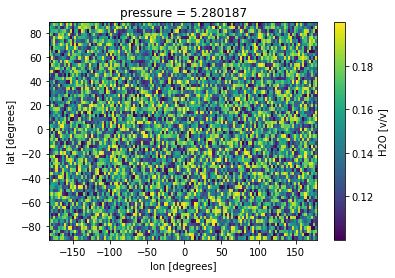

In [5]:
all_gcm['H2O'].isel(z=10).plot(x='lon',y='lat')

### Auto-regrid all 3D input

verbose=True;regrid=True; Regridding 3D output to ngangle=20, ntangle=20, with phase=0.


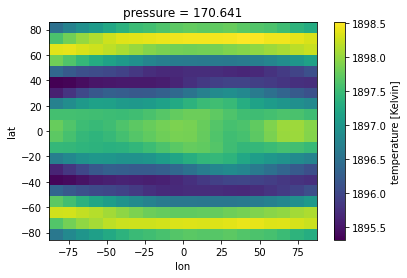

In [6]:
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_tangle=20, num_gangle=20)
case_3d.atmosphere_3d(all_gcm, regrid=True)

Note there is no print warning about missing abundance info since we have added it directly to the input `xarray`

### See regridded abundance input

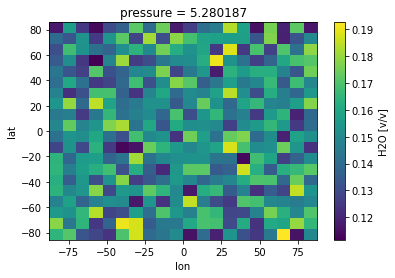

In [7]:
case_3d.inputs['atmosphere']['profile']['H2O'].isel(z=10).plot(
    x='lon',y='lat')

## Post-Process Chemistry: Chemical Equilibrium

We will run this example on a very coarse (5x5) grid to make it faster.

First step is the same a above but you will notice a warning that we have yet to add chemistry.

verbose=True;regrid=True; Regridding 3D output to ngangle=5, ntangle=5, with phase=0.
verbose=True;Only one data variable included. Make sure to add in chemical abundances before trying to run spectra.


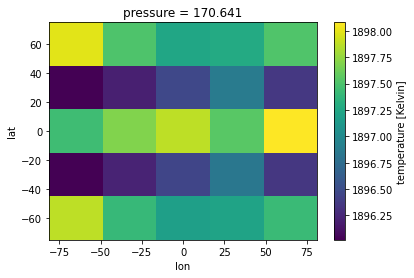

In [8]:
gcm_no_chem =  jdi.HJ_pt_3d(as_xarray=True)
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_tangle=5, num_gangle=5)
case_3d.atmosphere_3d(gcm_no_chem, regrid=True)

In [9]:
case_3d.chemeq_3d(n_cpu=4)#cpu sets parallelization (1=no parallelization)

### Plot 3D Chemistry 

Now we can see structure that intuitively makes sense. Near the equator, where temperatures are hotter, there is less CH4. 

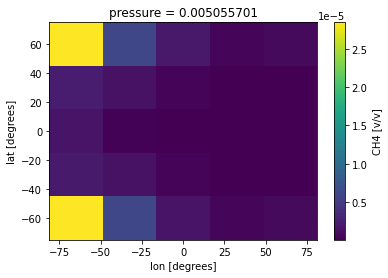

In [10]:
case_3d.inputs['atmosphere']['profile']['CH4'].isel(z=30).plot(
    x='lon',y='lat')

## Post-Process Clouds: User Defined Input

Here we will add some simple banded structure to the `PICASO` clouds.

Coming soon!